In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
first_date = session.query(Measurement.date).order_by(Measurement.date).first()
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"First date of the datapoint: {first_date[0]}")
print(f"Last date of the datapoint:{last_date[0]}")


year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(f"Year before the last date:", year_ago)

First date of the datapoint: 2010-01-01
Last date of the datapoint:2017-08-23
Year before the last date: 2016-08-23


In [11]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
lastdate = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
query_date = dt.date(lastdate.year -1, lastdate.month, lastdate.day)
query_date

sel = [Measurement.date,Measurement.prcp]
query_result = session.query(*sel).filter(Measurement.date >= query_date).all()

PA = pd.DataFrame(query_result, columns=['Date','Precipitation']) # PA= Precipitation Analysis
PA = PA.dropna(how='any')
PA = PA.sort_values(["Date"], ascending=True)
PA = PA.set_index("Date")
PA.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


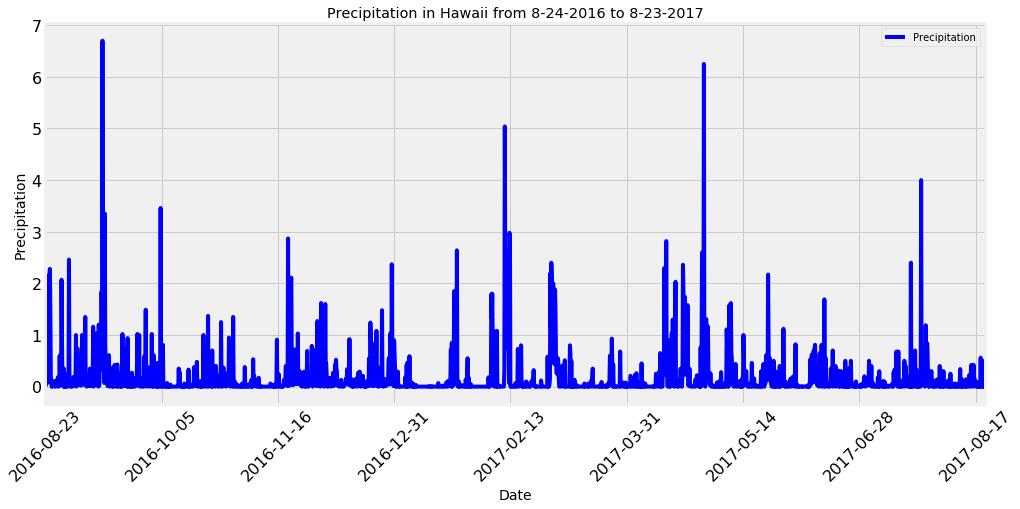

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
PA.plot(figsize=(15, 7),sort_columns=True,rot=45,use_index=True,title='Precipitation in Hawaii from 8-24-2016 to 8-23-2017',
                   legend=True,fontsize=16,grid=True,color='blue')
plt.ylabel('Precipitation', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
PA.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel_1 = [Measurement.station,func.count(Measurement.id)]
active_stations = session.query(*sel_1).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel_2 = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_station = session.query(*sel_2).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
most_active_station

(54.0, 85.0, 71.66378066378067)

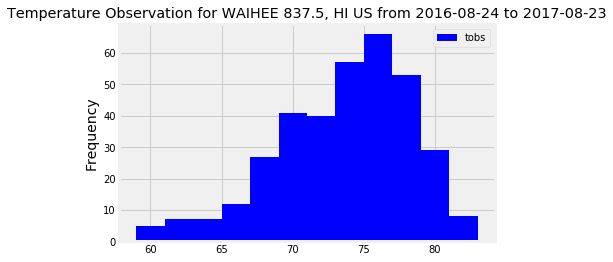

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_1 = session.query(Measurement.tobs).filter(Measurement.station == active_stations[0][0]).\
                filter(Measurement.date >= query_date).all()
temp = list(np.ravel(query_1))

sel_3 = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
query_2 = session.query(*sel_3).all()
stations_desc = pd.DataFrame(query_2, columns=['Station','Name','Latitude','Longitude','Elevation'])

station_name = stations_desc.loc[stations_desc["Station"] == active_stations[0][0],"Name"].tolist()[0]

plt.hist(temp, bins=12, color='blue')
plt.title("Temperature Observation for %s from 2016-08-24 to 2017-08-23" % (station_name))
plt.ylabel('Frequency', fontsize=14)
labels = ['tobs']
plt.legend(labels)
plt.show()

## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startdate = '2016-01-01'
enddate = '2016-01-15'
tempresult = calc_temps(startdate,enddate)[0]
tempresult

(62.0, 69.70786516853933, 78.0)

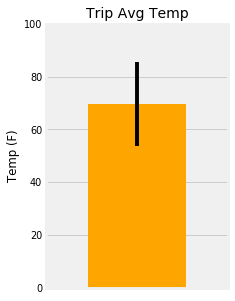

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = [0]
y_pos = [tempresult[1]]
error = [(tempresult[2] - tempresult[0])]

w = 3
h = 5
d = 70
plt.figure(figsize=(w, h), dpi=d)
plt.bar(x_pos,y_pos,color='orange', yerr=error)
plt.xlim(-0.75,0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
startdate = '2016-01-01'
enddate = '2016-01-15'

sel_4 = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
query_result = session.query(*sel_4).filter(Station.station == Measurement.station).group_by(Measurement.station).\
    filter(Measurement.date >= startdate).filter(Measurement.date <= enddate).\
    order_by(func.sum(Measurement.prcp).desc()).all()
  
stations = pd.DataFrame(query_result, columns=['Station','Name','Latitude','Longitude','Elevation','PrcpSum'])
stations

,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.94
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.03
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.69
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.61
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.23
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.13
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

startdate = '2017-01-01'
enddate = '2017-01-15'

dtobj = dt.datetime.strptime(startdate, '%Y-%m-%d')
enddtobj = dt.datetime.strptime(enddate, '%Y-%m-%d')

tripdates = []
normals =[]
while (dtobj <= enddtobj):
    tripdates.append(dt.datetime.strftime(dtobj,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(dtobj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    dtobj = dtobj + dt.timedelta(days = 1)

normals

[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0],
 [57.0, 67.16071428571429, 75.0],
 [58.0, 67.9298245614035, 78.0],
 [62.0, 69.74137931034483, 77.0],
 [57.0, 67.3103448275862, 78.0],
 [57.0, 67.4074074074074, 81.0],
 [57.0, 67.25454545454545, 77.0],
 [58.0, 69.52631578947368, 77.0],
 [56.0, 69.31372549019608, 78.0]]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
trip['Date'] = tripdates
trip_1 = trip.set_index("Date")
trip_1

,tmin,tavg,tmax
Date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0
2017-01-08,57.0,67.160714,75.0
2017-01-09,58.0,67.929825,78.0


(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 <a list of 8 Text xticklabel objects>)

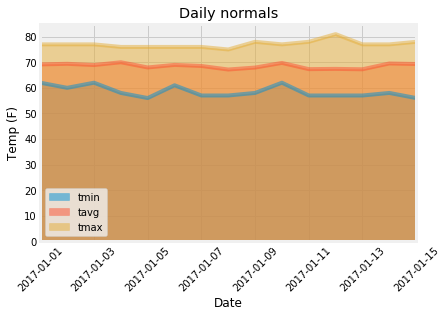

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
trip_1.plot.area(stacked=False)
plt.title("Daily normals")
plt.ylabel("Temp (F)")
plt.xticks(rotation=45)